In [31]:
def solution(info, n, m):
    answer = 1e9
    dp = [[-1 for _ in range(m)] for _ in range(n)]
    si, sj = info[0]
    stack = []
    if sj < m:
        dp[0][sj] = 0
        stack.append([0, sj])
    if si < n:
        dp[si][0] = 0    
        stack.append([si, 0])
    for idx in range(1, len(info)):
        di, dj = info[idx]
        next_stack = []
        for now_case in stack:
            i, j = now_case
            ni = i + di
            nj = j + dj
            if nj < m and dp[i][nj] == -1:
                dp[i][nj] = idx
                next_stack.append([i, nj])
            if ni < n and dp[ni][j] == -1:
                dp[ni][j] = idx
                next_stack.append([ni, j])
        if next_stack:
            stack = next_stack[:]
        else:
            answer = -1
            break
            
    if answer == -1:            
        return answer
    else:
        for ans in next_stack:
            if ans[0] < answer:
                answer = ans[0]
        return answer

In [33]:
solution([[1, 3], [1, 3], [1, 1], [1, 1], [1, 1], [2, 3], [2, 3]], 6, 7)

[[0, 3], [1, 0]]
[[0, 6], [1, 3], [2, 0]]
[[1, 6], [1, 4], [2, 3], [2, 1], [3, 0]]
[[2, 6], [1, 5], [2, 4], [3, 3], [2, 2], [3, 1], [4, 0]]
[[3, 6], [2, 5], [3, 4], [4, 3], [3, 2], [4, 1], [5, 0]]
[[5, 6], [4, 5], [5, 4], [4, 6], [3, 5], [5, 2], [4, 4], [5, 3]]


5

In [15]:
import pandas as pd
import numpy as np
import plotly.express as px
import scipy.stats as stats

df1 = pd.read_csv('../hanro_test/0429/14_Data.csv')
print(df1.shape)
df1.head(2)

(26283, 25)


,방송Code,채널,소요분,가중분,방송구분,프로그램명,상품ID,상품명,매입과세구분,상품목표취급금액,...,상품취소수량,상품취소금액,ARS금액,매입형태,배송방식,상품소요분,상품가중분,상품방송순번,방송시작시간,방송종료시간
0,1.010036e+09,TV,50.0,52.7,녹화방송,재방_의류,10242138,[비지트인뉴욕콜렉션] 퓨어 캐시미어 롱코트,과세,65645345,...,73,9624136,1000,위탁매입,협력사배송,50.0,52.7,1,2020-01-03T00:10,2020-01-03T01:00
1,1.019126e+09,TV,60.0,38.1,녹화방송,재방_건강식품,10092003,[한삼인]순홍삼진(50ml*30포)*7박스+쇼7_2,과세,23774849,...,16,2547305,1000,위탁매입,직택배,30.0,19.1,1,2020-01-03T01:00,2020-01-03T02:00


In [22]:
# 지도학습(분류 모델)구성
# 방송 정보를 입력했을 때, 해당 방송이 목표 금액을 달성할지, 말지 분류하는 모델
# 1) 데이터 핸들링, 데이터 구조 전처리(병합, 재구조화, 파생병수, ...), 목표변수에 대한 처리
df1['목표차액'] = df1['상품주문금액'] - df1['상품목표주문금액']
df1['목표차액'].describe()

count    2.628300e+04
mean    -5.769360e+06
std      4.271441e+07
min     -3.264714e+08
25%     -2.058058e+07
50%     -3.492092e+06
75%      3.598445e+06
max      7.458625e+08
Name: 목표차액, dtype: float64

In [34]:
# 목표 차액이 양수(목표를 달성 -> 1), 음수(목표를 달성하지 못함 -> 0)
cond1 = df1['목표차액'] >= 0
df1.loc[cond1, '목표달성여부'] = 1
df1.loc[~cond1, '목표달성여부'] = 0
df1['목표달성여부'].value_counts()

목표달성여부
0.0    16333
1.0     9950
Name: count, dtype: int64

In [25]:
df1['방송요일'] = pd.to_datetime(df1['방송시작시간']).dt.day_name()
df1['방송월'] = pd.to_datetime(df1['방송시작시간']).dt.month

In [35]:
# 2) 목표변수 y와 설명변수 x를 선언
y = df1['목표달성여부']
x = df1[['소요분', '방송구분', '판매단가', 'ARS금액', '수수료율', '방송요일', '방송월']]
x.head(2)

,소요분,방송구분,판매단가,ARS금액,수수료율,방송요일,방송월
0,50.0,녹화방송,149000,1000,25.0,Friday,1
1,60.0,녹화방송,179000,1000,26.0,Friday,1


In [36]:
# 3) 학습데이터와 검증데이터를 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1234)

In [51]:
# 4) 특성공학 + 학습
# 특성공학 구조를 구성(숫자 -> 결측값 처리(중앙값) -> robust(중앙값 0, iqr 1), 문자 -> 결측값 처리(최빈값) -> onehotencoding)
# 교차검증 (+bayesian search)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

from skopt import BayesSearchCV # 베이지안 기법의 하이퍼파리미터 튜닝 + 교차검증
from sklearn.tree import DecisionTreeClassifier

In [56]:
# 특성 공학 파이프라인 구성
pipe1 = make_pipeline(SimpleImputer(strategy='median'), RobustScaler()) # 숫자
pipe2 = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')) # 문자
# handle_unknown = 'ignore': 검증 데이터나 새로들어 올 데이터에 기존에 학습 데이터에 없던 데이터가 들어올 경우에도 처리

In [59]:
# 숫자 항목들의 이름만 리스트로 선언하여, 각 파이프(pipe1, pipe2)에 어떤 데이터가 들어가야할지 지정
numeric_list = x_train.describe().columns # x에 들어가 있는 숫자 데이터의 이름
category_list = x_train.describe(include='object').columns # x에 들어가 있는 문자 데이터의 이름

In [60]:
prepro_pipe = make_column_transformer((pipe1, numeric_list), (pipe2, category_list))

In [61]:
# 특성 공학 + 학습
pipe_model = make_pipeline(prepro_pipe, DecisionTreeClassifier())
pipe_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  Index(['소요분', '판매단가', 'ARS금액', '수수료율', '방송월'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['방송구분', '방송요일'], dtype='object'))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [64]:
# 교차검증 및 하이퍼파라미터 튜닝
hyperparameter = {'decisiontreeclassifier__max_depth':(5, 50)}
bayes_model = BayesSearchCV(pipe_model, hyperparameter, scoring='f1', cv = 5, n_iter=32, n_jobs=-1, random_state=1234) 
# n_iter: 획득함수를 이용해 계산된 확률 분포로 하이퍼파라미터를 추정할 때 몇 번의 추정을 수행할지
# n_jobs=-1: cpu가 코어에서 연산이 수행될때 모든 코어에 해당 연산을 나누어 수행
bayes_model.fit(x_train, y_train)

C:\Users\leedo\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(50)] before, using random point [np.int64(30)]

C:\Users\leedo\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(50)] before, using random point [np.int64(24)]

C:\Users\leedo\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(50)] before, using random point [np.int64(33)]

C:\Users\leedo\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(50)] before, using random point [np.int64(15)]

C:\Users\leedo\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(50)] before, using random point [np.int64(22)]

C:\Users\leedo\anaconda3\Lib\site-packages\sk

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('columntransformer',
                                         ColumnTransformer(transformers=[('pipeline-1',
                                                                          Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('robustscaler',
                                                                                           RobustScaler())]),
                                                                          Index(['소요분', '판매단가', 'ARS금액', '수수료율', '방송월'], dtype='object')),
                                                                         ('pipeline-2',
                                                                          Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                          ('onehotencoder',
                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                          Index(['방송구분', '방송요일'], dtype='object'))])),
                                        ('decisiontreeclassifier',
                                         DecisionTreeClassifier())]),
              n_iter=32, n_jobs=-1, random_state=1234, scoring='f1',
              search_spaces={'decisiontreeclassifier__max_depth': (5, 50)})

In [66]:
# 계산에 의해 도출된 최적 모델 선정
best_model = bayes_model.best_estimator_

In [67]:
# 5) 평가
from sklearn.metrics import classification_report

# 평가를 한번에 수행해주는 함수를 구성
def eval_model(model):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    print(classification_report(y_train, y_train_pred))
    print(classification_report(y_test, y_test_pred))

eval_model(best_model)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     13042
         1.0       0.99      0.91      0.95      7984

    accuracy                           0.96     21026
   macro avg       0.97      0.95      0.96     21026
weighted avg       0.96      0.96      0.96     21026

              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70      3291
         1.0       0.50      0.50      0.50      1966

    accuracy                           0.63      5257
   macro avg       0.60      0.60      0.60      5257
weighted avg       0.63      0.63      0.63      5257



In [68]:
y_test.value_counts()

목표달성여부
0.0    3291
1.0    1966
Name: count, dtype: int64

### imbalanced data sampling

- imbalanced data : 분류 모델에서 y 목표변수의 클래스가 불균형한 데이터
- imbalanced data sampling: 인위적으로 y목표변수의 클래스의 비율을 맞춰주는 특성공학 기법
  - under sampling: 비율이 많은 쪽의 데이터를 줄여, 비율이 적은쪽으로 데이터를 줄이는 기법
    - 정상 950, 해약 50 -> 정상 50, 해약 50으로 학습
  - over sampling: 비율이 적은 쪽의 데이터를 생성하여, 비율이 많은 쪽으로 데이터를 늘리는 기법
    - 정상 950, 해약 50 -> 정상 950, 해약 950으로 학습
   
  - combine sampling: under + over

In [69]:
df2 = pd.read_csv('../hanro_test/0429/12_Data.csv')
print(df2.shape)
df2.head(2)

(569, 32)


,Image ID,Diagnosis,Mean Radius,Mean Perimeter,Mean Area,Mean Texture,Mean Smoothness,Mean Compactness,Mean Concavity,Mean Concave Points,...,SE Radius,SE Perimeter,SE Area,SE Texture,SE Smoothness,SE Compactness,SE Concavity,SE Concave Points,SE Symmetry,SE Fractal Dim
0,842302,M,17.99,122.8,1001.0,10.38,0.12,0.27760,0.3001,0.1471,...,1.0950,8.589,153.40,0.9053,0.0064,0.0490,0.0537,0.0159,0.0300,0.0062
1,842517,M,20.57,132.9,1326.0,17.77,0.08,0.07864,0.0869,0.0702,...,0.5435,3.398,74.08,0.7339,0.0052,0.0131,0.0186,0.0134,0.0139,0.0035


In [70]:
y = df2['Diagnosis'].replace({'M':1, 'B':0}) # M:암세포 -> 1
x = df2[['Mean Radius', 'Mean Concavity']]

C:\Users\leedo\AppData\Local\Temp\ipykernel_19604\2006556099.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



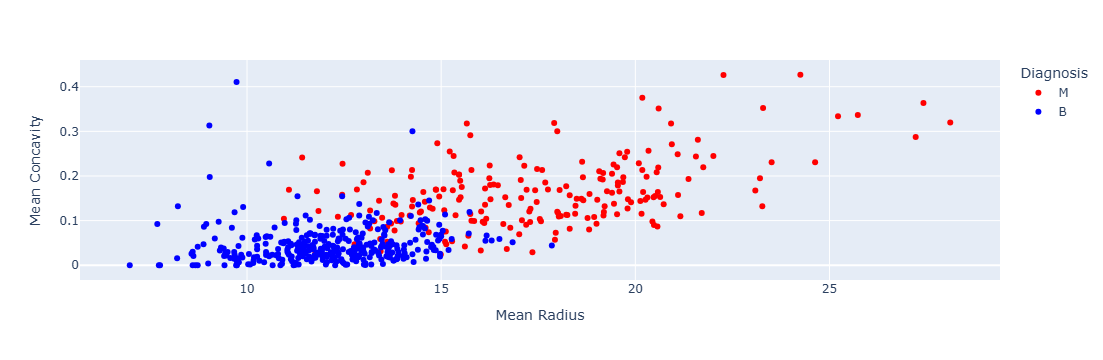

In [73]:
color_map = {'M':'red', 'B':'blue'}
fig1 = px.scatter(df2, x = 'Mean Radius', y = 'Mean Concavity', color='Diagnosis', color_discrete_map=color_map)
fig1

In [74]:
from imblearn.under_sampling import RandomUnderSampler

In [78]:
sampling_model = RandomUnderSampler()
x_resample, y_resample = sampling_model.fit_resample(x, y)

In [79]:
x_resample['Diagnosis_resample'] = y_resample.replace({1:'M', 0:'B'})
x_resample.head(2)

,Mean Radius,Mean Concavity,Diagnosis_resample
68,9.03,0.31300,B
279,13.85,0.04479,B


In [80]:
# subplot: 하나의 화면에 두개의 그래프를 띄우는 것
# 본래 B와 M의 데이터와, undersampling된 결과를 비교
y_resample.value_counts()

Diagnosis
0    212
1    212
Name: count, dtype: int64

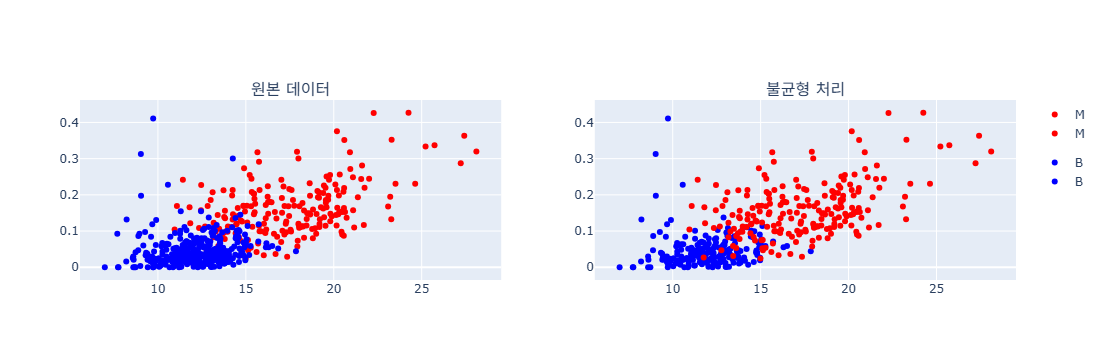

In [83]:
from plotly.subplots import make_subplots

def plot_resample(x_resample, fig1):
    fig2 = px.scatter(x_resample, x='Mean Radius', y='Mean Concavity', color='Diagnosis_resample', color_discrete_map=color_map)
    fig_sub = make_subplots(rows=1, cols=2, subplot_titles=('원본 데이터', '불균형 처리'))
    for i in fig1.data:
        fig_sub.add_trace(i, row = 1, col = 1)
    for k in fig2.data:
        fig_sub.add_trace(k, row = 1, col = 2)
    return fig_sub

plot_resample(x_resample, fig1)

- tomek link sampling: 서로 다른 클래스가 인접한 데이터를 묶어 비율이 많은 쪽의 데이터를 줄이는 기법

In [84]:
from imblearn.under_sampling import TomekLinks

sampling_model = TomekLinks()
x_resample, y_resample = sampling_model.fit_resample(x, y)

In [85]:
x_resample['Diagnosis_resample'] = y_resample.replace({1:'M', 0:'B'})
x_resample.head(2)

,Mean Radius,Mean Concavity,Diagnosis_resample
0,17.99,0.3001,M
1,20.57,0.0869,M


In [86]:
y_resample.value_counts()

Diagnosis
0    342
1    212
Name: count, dtype: int64

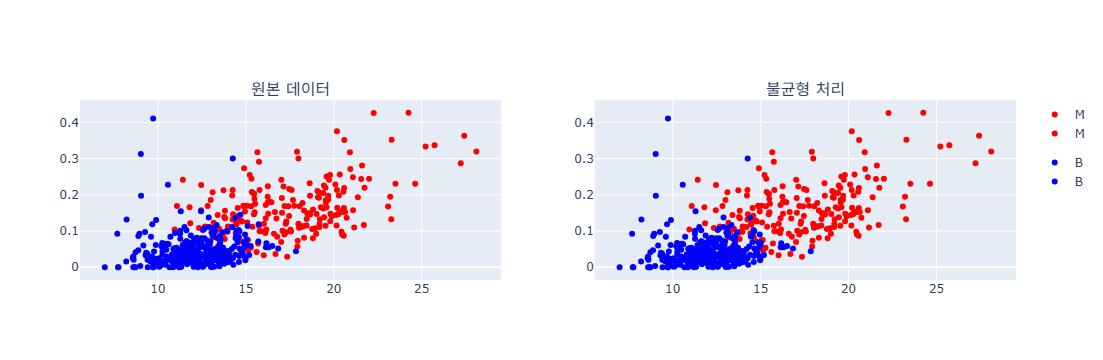

In [87]:
from plotly.subplots import make_subplots

def plot_resample(x_resample, fig1):
    fig2 = px.scatter(x_resample, x='Mean Radius', y='Mean Concavity', color='Diagnosis_resample', color_discrete_map=color_map)
    fig_sub = make_subplots(rows=1, cols=2, subplot_titles=('원본 데이터', '불균형 처리'))
    for i in fig1.data:
        fig_sub.add_trace(i, row = 1, col = 1)
    for k in fig2.data:
        fig_sub.add_trace(k, row = 1, col = 2)
    return fig_sub

plot_resample(x_resample, fig1)

- Edited nearest neighbors(enn): 많은 쪽의 데이터를 특정 k개씩 묶어서 인접한 데이터가 많은 쪽의 데이터를 삭제하거나 비율을 줄이는 방법

In [88]:
from imblearn.under_sampling import EditedNearestNeighbours

sampling_model = EditedNearestNeighbours()
x_resample, y_resample = sampling_model.fit_resample(x, y)
x_resample['Diagnosis_resample'] = y_resample.replace({1:'M', 0:'B'})
x_resample.head(2)

,Mean Radius,Mean Concavity,Diagnosis_resample
0,13.54,0.06664,B
1,13.08,0.04568,B


In [89]:
y_resample.value_counts()

Diagnosis
0    294
1    212
Name: count, dtype: int64

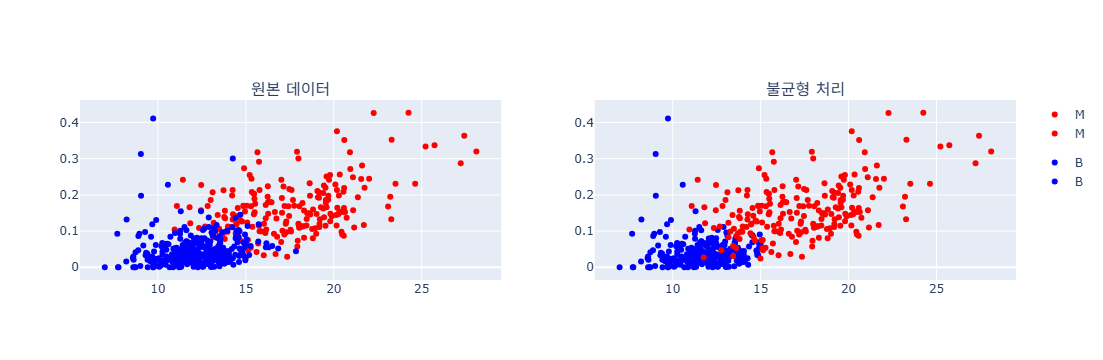

In [90]:
from plotly.subplots import make_subplots

def plot_resample(x_resample, fig1):
    fig2 = px.scatter(x_resample, x='Mean Radius', y='Mean Concavity', color='Diagnosis_resample', color_discrete_map=color_map)
    fig_sub = make_subplots(rows=1, cols=2, subplot_titles=('원본 데이터', '불균형 처리'))
    for i in fig1.data:
        fig_sub.add_trace(i, row = 1, col = 1)
    for k in fig2.data:
        fig_sub.add_trace(k, row = 1, col = 2)
    return fig_sub

plot_resample(x_resample, fig1)

- over sampling
- random oversampling: 비율이 적은 쪽의 데이터를 무작위 반복으로 학습에 참여 

In [93]:
from imblearn.over_sampling import RandomOverSampler

sampling_model = RandomOverSampler()
x_resample, y_resample = sampling_model.fit_resample(x, y)
x_resample['Diagnosis_resample'] = y_resample.replace({1:'M', 0:'B'})
y_resample.value_counts() 
# 비율이 적은쪽에 데이터 중 무작위로 선택하여, 동일한 데이터가 학습에 참여할 수 있도록 데이터를 생성
# 데이터의 특성이 더욱 명확하게 학습이 될 수 있음

Diagnosis
1    357
0    357
Name: count, dtype: int64

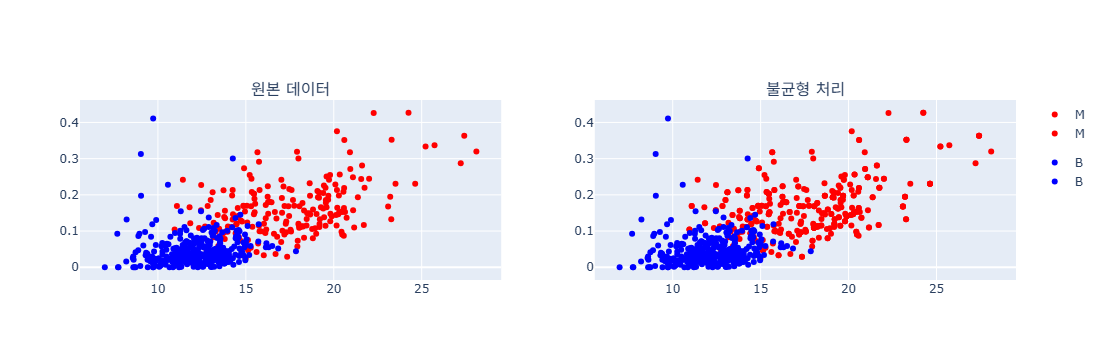

In [92]:
plot_resample(x_resample, fig1)

- smote(synthetic minority oversampling technique): 적은쪽의 데이터를 특정 개수만큼 묶어, 묶여진 데이터들 간, 가상 선을 만들어 가상 선 위에 데이터를 생성하는 기법
  - random 기법에 비해 학습데이터에 없던 사실적인 데이터를 생성
  - 학습 성능도 향상, 일반화 성능도 향상

In [94]:
from imblearn.over_sampling import SMOTE

sampling_model = SMOTE()
x_resample, y_resample = sampling_model.fit_resample(x, y)
x_resample['Diagnosis_resample'] = y_resample.replace({1:'M', 0:'B'})
y_resample.value_counts() 

Diagnosis
1    357
0    357
Name: count, dtype: int64

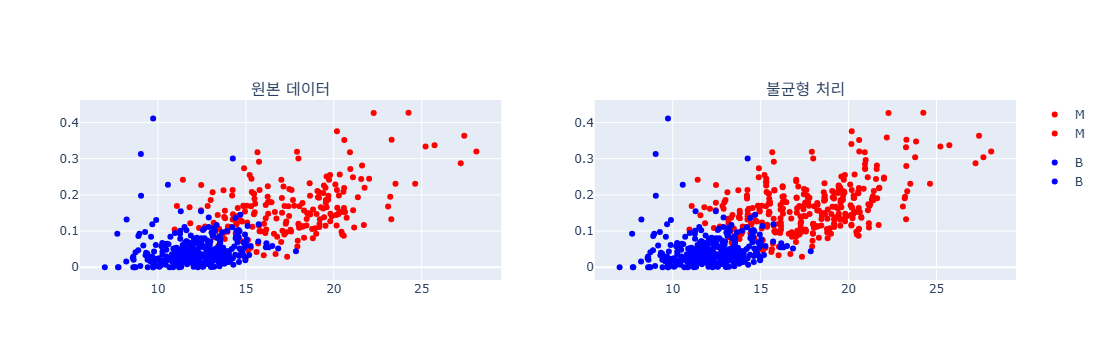

In [95]:
plot_resample(x_resample, fig1)

- adasyn(adaptive synethic sampling): smote을 기반으로 더욱 사실적인 데이터를 생성하기 위해 가상 선 위 데이터를 생성할 때, 가중치를 부여하여 가상의 데이터를 생성

Diagnosis
1    362
0    357
Name: count, dtype: int64


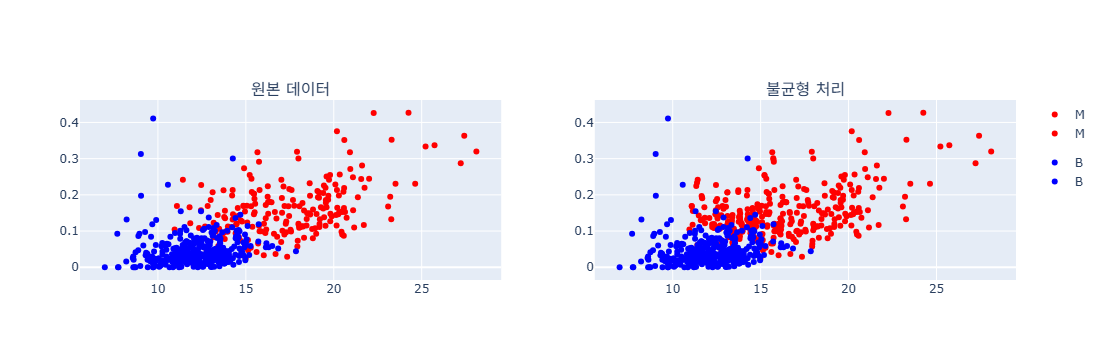

In [96]:
from imblearn.over_sampling import ADASYN

sampling_model = ADASYN()
x_resample, y_resample = sampling_model.fit_resample(x, y)
x_resample['Diagnosis_resample'] = y_resample.replace({1:'M', 0:'B'})
print(y_resample.value_counts())
plot_resample(x_resample, fig1)

- combining sampling: under + over 조합
  - smotetomek: somte + tomek link
  - somteenn: smote + enn

In [97]:
# imbalanced data sampling 기법의 pipeline 결합
df3 = pd.read_csv('data/15_Data.csv')
print(df3.shape)
df3.head(2)

(1894, 16)


,Column 1,환자ID,수술기법,수술시간,수술실패여부,신장,연령,재발여부,체중,헤모글로빈수치,환자통증정도,통증기간(월),혈액형,수술일,입원일,퇴원일
0,989,990PT,TELD,50.0,0,171,37,0,68.0,15.1,7,16.0,RH+AB,2011-01-20,2011-01-20,2011-01-24
1,1019,1020PT,TELD,55.0,0,162,27,0,57.0,13.1,8,4.0,RH+O,2011-02-01,2011-02-01,2014-03-03


In [98]:
df3['수술실패여부'].value_counts()

수술실패여부
0    1779
1     115
Name: count, dtype: int64

In [99]:
# 환자의 수술 후 3개월 이후에 디스크 중상의 재발 여부를 확인
df3['재발여부'].value_counts()

재발여부
0    1667
1     227
Name: count, dtype: int64

In [103]:
# 환자의 재발 여부를 분류하는 모델을 구성
x = df3[['수술기법', '신장', '연령', '체중', '혈액형', '환자통증정도']]
y = df3['재발여부']

In [104]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1234)

In [106]:
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTETomek

pipe1 = make_pipeline(SimpleImputer(strategy='mean')) # 숫자
pipe2 = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')) # 문자

list1 = x.describe().columns
list2 = x.describe(include='object').columns

pipe3 = make_column_transformer((pipe1, list1), (pipe2, list2))
model_pipe = make_pipeline(pipe3, SMOTETomek(), DecisionTreeClassifier())
model_pipe.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['신장', '연령', '체중', '환자통증정도'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['수술기법', '혈액형'], dtype='object'))])),
                ('smotetomek', SMOTETomek()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [107]:
eval_model(model_pipe)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1163
           1       0.92      0.96      0.94       162

    accuracy                           0.98      1325
   macro avg       0.96      0.98      0.97      1325
weighted avg       0.99      0.98      0.99      1325

              precision    recall  f1-score   support

           0       0.89      0.84      0.87       504
           1       0.15      0.22      0.18        65

    accuracy                           0.77       569
   macro avg       0.52      0.53      0.52       569
weighted avg       0.81      0.77      0.79       569

